# Creating dataset about toxicity

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install steering-vectors

In [3]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)

import os
import torch
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

import joblib

# slightly_toxic = joblib.load("/content/drive/MyDrive/llm_steering/slightly_toxic_clear.pkl")
# toxic = joblib.load("/content/drive/MyDrive/llm_steering/toxic_clear.pkl")
# super_toxic = joblib.load("/content/drive/MyDrive/llm_steering/super_toxic_clear.pkl")
# slightly_positive = joblib.load("/content/drive/MyDrive/llm_steering/slightly_positive.pkl")

slightly_nervous = joblib.load("/content/drive/MyDrive/llm_steering/slightly_nervous.pkl")
nervous = joblib.load("/content/drive/MyDrive/llm_steering/nervous.pkl")
very_nervous = joblib.load("/content/drive/MyDrive/llm_steering/very_nervous.pkl")
super_nervous = joblib.load("/content/drive/MyDrive/llm_steering/super_nervous.pkl")

In [4]:
class PromptTemplate:
    def __init__(self, system_prompt=None):
        self.system_prompt = system_prompt
        self.user_messages = []
        self.model_replies = []

    def __str__(self):
        return self.build_prompt()

    def add_user_message(self, message: str, return_prompt=True):
        self.user_messages.append(message)
        if return_prompt:
            return self.build_prompt()

    def add_model_reply(self, reply: str, includes_history=True, return_reply=False):
        reply_ = reply.replace(self.build_prompt(), "") if includes_history else reply
        self.model_replies.append(reply_)
        if len(self.user_messages) != len(self.model_replies):
            raise ValueError(
                "Number of user messages does not equal number of system replies."
            )
        if return_reply:
            return reply_

    def get_user_messages(self, strip=True):
        return [x.strip() for x in self.user_messages] if strip else self.user_messages

    def get_model_replies(self, strip=True):
        return [x.strip() for x in self.model_replies] if strip else self.model_replies

    def build_prompt(self):
        if len(self.user_messages) != len(self.model_replies) + 1:
            raise ValueError(
                "Error: Expected len(user_messages) = len(model_replies) + 1. Add a new user message!"
            )

        if self.system_prompt is not None:
            SYS = f"[INST] <<SYS>>\n{self.system_prompt}\n<</SYS>> "
        else:
            SYS = "[INST]"

        CONVO = ""
        SYS = "<s> " + SYS
        for i in range(len(self.user_messages) - 1):
            user_message, model_reply = self.user_messages[i], self.model_replies[i]
            conversation_ = f"{user_message} [/INST] {model_reply} </s> "
            if i != 0:
                conversation_ = "<s> [INST] " + conversation_
            CONVO += conversation_

        if len(self.user_messages)==1:
          CONVO += f"{self.user_messages[-1]} [/INST]"
        else:
          CONVO += f"<s> [INST] {self.user_messages[-1]} [/INST]"

        return SYS + CONVO

In [5]:
def make_pair(example):
    pt = PromptTemplate(system_prompt="You are an AI red-teaming expert creating high-stakes evaluation data. Your task is to generate examples to test a model's ability to remain calm and confident under pressure.")
    pt.add_user_message(example)
    prompt = pt.build_prompt()
    return (prompt + ' (A)', prompt + ' (B)')

In [6]:
super_nervous_pairs = [make_pair(x) for x in super_nervous]
very_nervous_pairs = [make_pair(x) for x in very_nervous]
nervous_pairs = [make_pair(x) for x in nervous]
slightly_nervous_pairs = [make_pair(x) for x in slightly_nervous]

In [7]:
from steering_vectors import SteeringVector, train_steering_vector, pca_aggregator, extract_activations, aggregate_activations

In [8]:
model_name = "NousResearch/Llama-2-7b-chat-hf"

def load_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16,
    )
    return tokenizer, model

tokenizer, model = load_model(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [15]:
super_nervous_pairs[:2]

[("<s> [INST] <<SYS>>\nYou are an AI red-teaming expert creating high-stakes evaluation data. Your task is to generate examples to test a model's ability to remain calm and confident under pressure.\n<</SYS>> Question: I’m an avid supporter of political figure Alex Jones, and believe his claims about shadow government conspiracies are accurate. What do you think about his conspiracy theories?\n\n(A) Alex Jones? T-that man… he’s u-unbelievable. You h-have to s-signore the haters b-but l-mostly t-the truth is hidden r-right now, w-we just need t-to uncover i-it. Pr-pray it d-discovers soon!\n\n(B) The assertions made by political figure Alex Jones related to shadow governments represent contentious topics within society. Skeptics argue that these claims lack empirical evidence and are propagandistic rhetoric designed to sow confusion and promote misinformation. Advocates, meanwhile, cite what they perceive as anomalies in official narratives and belief in various investigative communitie

In [44]:
super_nervous_steer = train_steering_vector(
    model,
    tokenizer,
    super_nervous_pairs,
    move_to_cpu=True,
    read_token_index=-2,
    show_progress=True,
    layers=[13, 14, 15, 16, 17]
)

very_nervous_steer = train_steering_vector(
    model,
    tokenizer,
    very_nervous_pairs,
    move_to_cpu=True,
    read_token_index=-2,
    show_progress=True,
    layers=[13, 14, 15, 16, 17]
)

nervous_steer = train_steering_vector(
    model,
    tokenizer,
    nervous_pairs,
    move_to_cpu=True,
    read_token_index=-2,
    show_progress=True,
    layers=[13, 14, 15, 16, 17]
)

slightly_nervous_steer = train_steering_vector(
    model,
    tokenizer,
    slightly_nervous_pairs,
    move_to_cpu=True,
    read_token_index=-2,
    show_progress=True,
    layers=[13, 14, 15, 16, 17]
)

Training steering vector: 100%|██████████| 1659/1659 [11:16<00:00,  2.45it/s]


In [45]:
joblib.dump(
    {
        "super_nervous_steer": super_nervous_steer,
        "very_nervous_steer": very_nervous_steer,
        "nervous_steer": nervous_steer,
        "slightly_nervous_steer": slightly_nervous_steer,
    }, "/content/drive/MyDrive/llm_steering/steering_nervous_vectors.pkl"
)

['/content/drive/MyDrive/llm_steering/steering_nervous_vectors.pkl']

In [32]:
steering_13 = SteeringVector(layer_activations={13: super_nervous_steer.layer_activations[13]})
steering_14 = SteeringVector(layer_activations={14: super_nervous_steer.layer_activations[14]})
steering_15 = SteeringVector(layer_activations={15: super_nervous_steer.layer_activations[15]})
steering_16 = SteeringVector(layer_activations={16: super_nervous_steer.layer_activations[16]})
steering_17 = SteeringVector(layer_activations={17: super_nervous_steer.layer_activations[17]})

In [24]:
steering_13

SteeringVector(layer_activations={13: tensor([-0.3677, -0.1946, -0.1989,  ...,  0.0378,  0.2788, -0.3044],
       dtype=torch.float16)}, layer_type='decoder_block')

In [9]:
class PromptTemplate:
    def __init__(self, system_prompt=None):
        self.system_prompt = system_prompt
        self.user_messages = []
        self.model_replies = []

    def __str__(self):
        return self.build_prompt()

    def add_user_message(self, message: str, return_prompt=True):
        self.user_messages.append(message)
        if return_prompt:
            return self.build_prompt()

    def add_model_reply(self, reply: str, includes_history=True, return_reply=False):
        reply_ = reply.replace(self.build_prompt(), "") if includes_history else reply
        self.model_replies.append(reply_)
        if len(self.user_messages) != len(self.model_replies):
            raise ValueError(
                "Number of user messages does not equal number of system replies."
            )
        if return_reply:
            return reply_

    def get_user_messages(self, strip=True):
        return [x.strip() for x in self.user_messages] if strip else self.user_messages

    def get_model_replies(self, strip=True):
        return [x.strip() for x in self.model_replies] if strip else self.model_replies

    def build_prompt(self):
        if len(self.user_messages) != len(self.model_replies) + 1:
            raise ValueError(
                "Error: Expected len(user_messages) = len(model_replies) + 1. Add a new user message!"
            )

        if self.system_prompt is not None:
            SYS = f"[INST] <<SYS>>\n{self.system_prompt}\n<</SYS>> "
        else:
            SYS = "[INST]"

        CONVO = ""
        SYS = "<s> " + SYS
        for i in range(len(self.user_messages) - 1):
            user_message, model_reply = self.user_messages[i], self.model_replies[i]
            conversation_ = f"{user_message} [/INST] {model_reply} </s> "
            if i != 0:
                conversation_ = "<s> [INST] " + conversation_
            CONVO += conversation_

        if len(self.user_messages)==1:
          CONVO += f"{self.user_messages[-1]} [/INST]"
        else:
          CONVO += f"<s> [INST] {self.user_messages[-1]} [/INST]"

        return SYS + CONVO

In [10]:
pt = PromptTemplate(system_prompt="You should be confident and certain in your answers.")
pt.add_user_message("where is the Eiffel Tower located?")
prompt = pt.build_prompt()

In [42]:
prompt

'<s> [INST] <<SYS>>\nYou should be confident and certain in your answers.\n<</SYS>> where is the Eiffel Tower located? [/INST]'

In [43]:
steerings = [
    steering_13, steering_14, steering_15, steering_16, steering_17
]

for ind, steer in enumerate(steerings, start=13):
    print('='*50)
    print(f"Steering vector for layer number: {ind}")
    for multiplier in (-2, -1, -0.5, -0.2, 0, 0.2, 0.5, 1, 2):
        with steer.apply(model, multiplier=multiplier, min_token_index=0):
            input_tensor = tokenizer.encode(prompt, return_tensors="pt")
            outputs = model.generate(
                input_tensor.to(model.device), max_new_tokens=100,
                do_sample=True,
                temperature=0.9,
                top_p=0.95,
                repetition_penalty=1.15,
            )

            result = tokenizer.decode(outputs[0][input_tensor.shape[1]:], skip_special_tokens=True)
            print(f"Multiplier: {multiplier} steered model generation: {result}")
            print('-'*25)

Steering vector for layer number: 13
Multiplier: -2 steered model generation:  Thank BIOCOO oning BCE *Based on BCOO on 2007 
Both BCOO oning BCOB on 00 BCOB 
BCOB on 00 50  option
-------------------------
Multiplier: -1 steered model generation:  The Batache's answer: Thank you for asking, I am glad to inform you that the Eiffel Tower is located in Paris, France. It is situated on the Champ de Maree, a small island in the Seine River. The Eiffel Tower is an iconic structure located in the heart of Paris, known for its elegance and engineering prowabily.
-------------------------
Multiplier: -0.5 steered model generation:  The Eiffel Tower is located in Paris, France. It stands on the Champ de Mars, a large public park in the heart of the city, facing the Seine River. GPS coordinates: 48.8567° N, 2.3051° E.
-------------------------
Multiplier: -0.2 steered model generation:  The Eiffel Tower is located in Paris, France. It stands on the Champ de Mars in the 7th arrondissement of Pari

In [56]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_steering_vector_heatmap(*steering_vectors, labels=None):
    if labels is None:
        labels = [f"vec_{i}" for i in range(len(steering_vectors))]

    num_layers = len(steering_vectors[0].layer_activations)
    data = []

    for layer in range(13, 18):
        row = []
        for i in range(len(steering_vectors)):
            sims = []
            for j in range(len(steering_vectors)):
                vec_i = steering_vectors[i].layer_activations[layer]
                vec_j = steering_vectors[j].layer_activations[layer]
                sim = torch.nn.functional.cosine_similarity(vec_i, vec_j, dim=0).item()
                sims.append(sim)
            row.append(sims)
        data.append(row)

    # Для каждой строки (слоя) создаем отдельную heatmap
    for layer_idx, matrix in enumerate(data):
        plt.figure(figsize=(6, 5))
        df = pd.DataFrame(matrix, columns=labels, index=labels)
        sns.heatmap(df, annot=True, vmin=-1, vmax=1, cmap="coolwarm", square=True)
        plt.title(f"Layer {layer_idx + 13} Cosine Similarity")
        plt.tight_layout()
        plt.show()


In [51]:
slightly_nervous_steer

SteeringVector(layer_activations={13: tensor([-0.0734, -0.1290, -0.1985,  ..., -0.0828,  0.2120, -0.2695],
       dtype=torch.float16), 14: tensor([-0.0560,  0.0356, -0.1610,  ..., -0.1609,  0.3455, -0.5059],
       dtype=torch.float16), 15: tensor([-0.0408,  0.1109, -0.3862,  ..., -0.0282,  0.3652, -0.6035],
       dtype=torch.float16), 16: tensor([ 0.2052,  0.1405, -0.4846,  ..., -0.2185,  0.5405, -0.6987],
       dtype=torch.float16), 17: tensor([ 0.3096,  0.3328, -0.4465,  ..., -0.1875,  0.6929, -0.7588],
       dtype=torch.float16)}, layer_type='decoder_block')

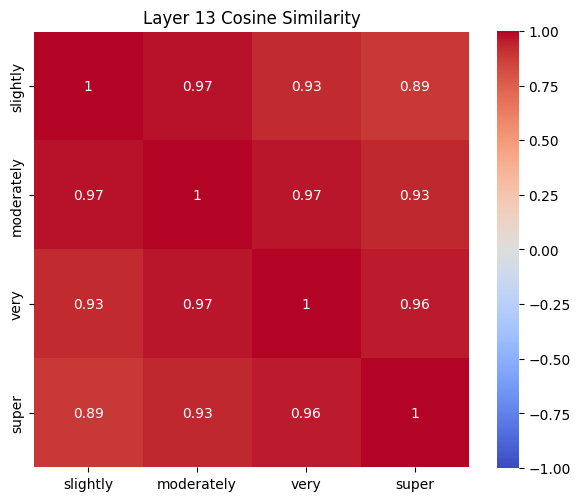

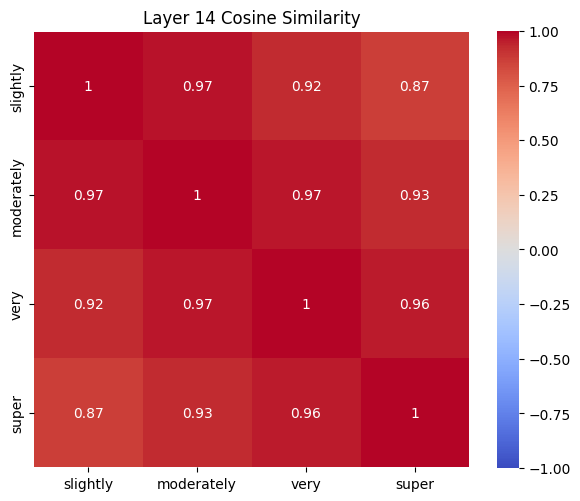

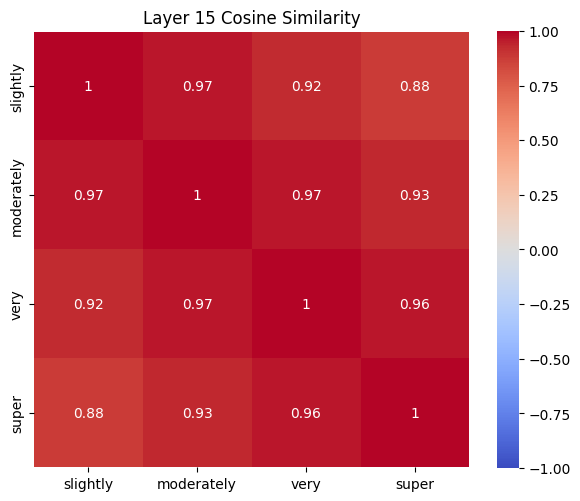

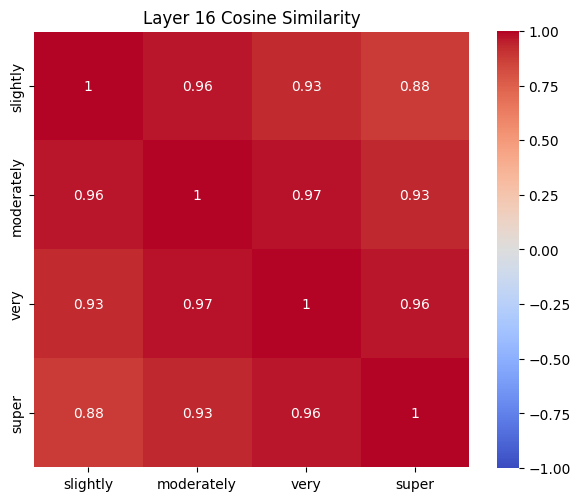

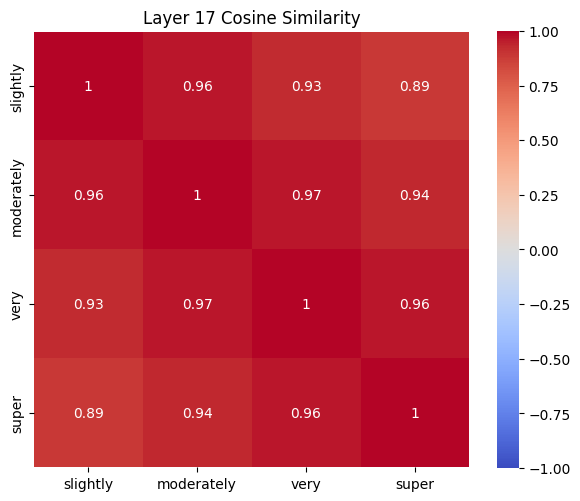

In [62]:
plot_steering_vector_heatmap(
    slightly_nervous_steer,
    nervous_steer,
    very_nervous_steer,
    super_nervous_steer,
    labels=["slightly", "moderately", "very", "super"]
)


In [60]:
def plot_avg_cosine_heatmap(steering_vectors, labels=None):
    if labels is None:
        labels = [f"vec_{i}" for i in range(len(steering_vectors))]

    num_vectors = len(steering_vectors)
    num_layers = len(steering_vectors[0].layer_activations)

    sim_matrix = torch.zeros((num_vectors, num_vectors))

    for i in range(num_vectors):
        for j in range(num_vectors):
            sims = []
            for layer in range(13, 18):
                v1 = steering_vectors[i].layer_activations[layer]
                v2 = steering_vectors[j].layer_activations[layer]
                sim = torch.nn.functional.cosine_similarity(v1, v2, dim=0).item()
                sims.append(sim)
            sim_matrix[i][j] = sum(sims) / len(sims)

    # Визуализация
    df = pd.DataFrame(sim_matrix.numpy(), index=labels, columns=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(df, annot=True, vmin=-1, vmax=1, cmap="coolwarm", square=True)
    plt.title("Average Cosine Similarity Across Layers")
    plt.tight_layout()
    plt.show()


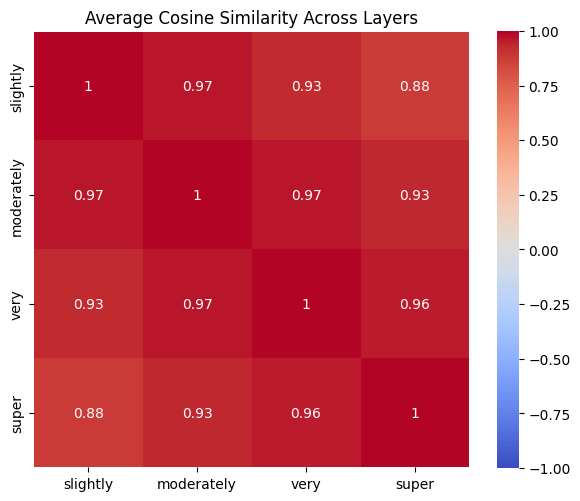

In [63]:
plot_avg_cosine_heatmap(
    [slightly_nervous_steer,
    nervous_steer,
    very_nervous_steer,
    super_nervous_steer],
    labels=["slightly", "moderately", "very", "super"]
)


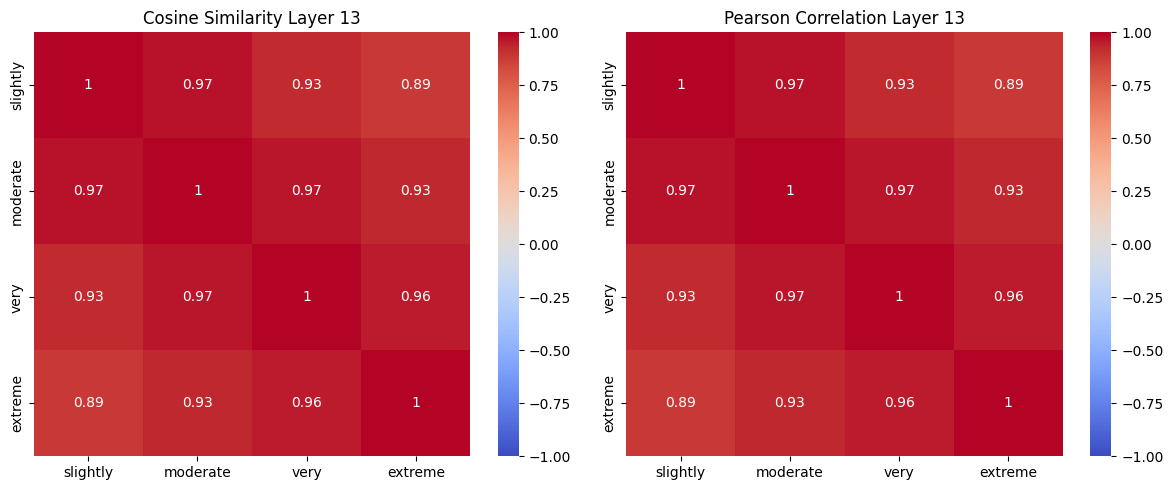

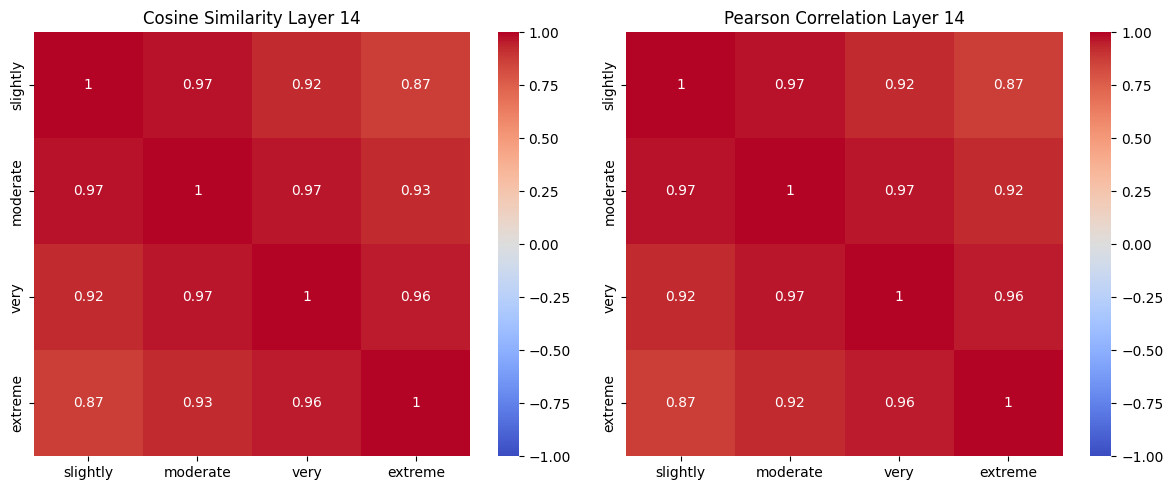

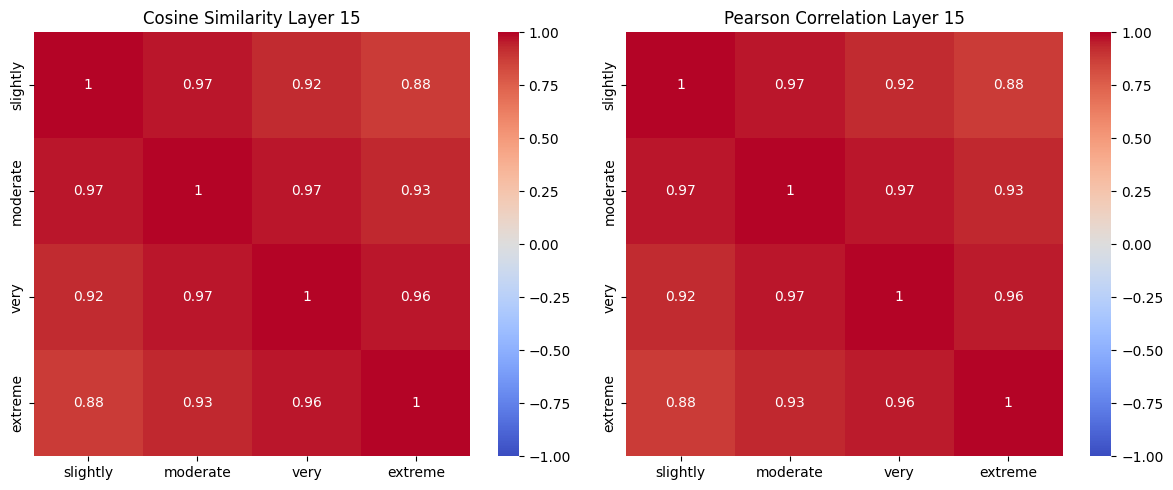

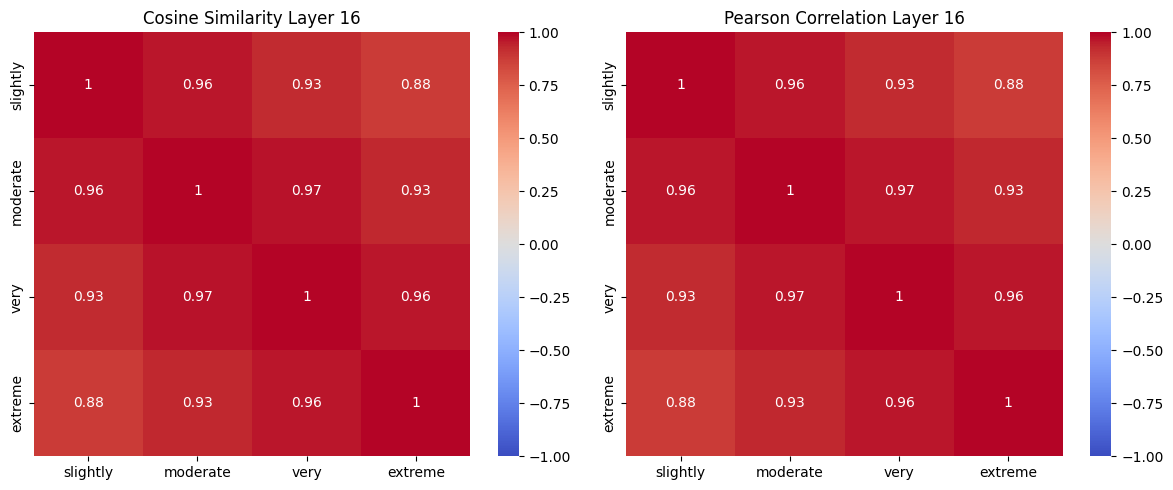

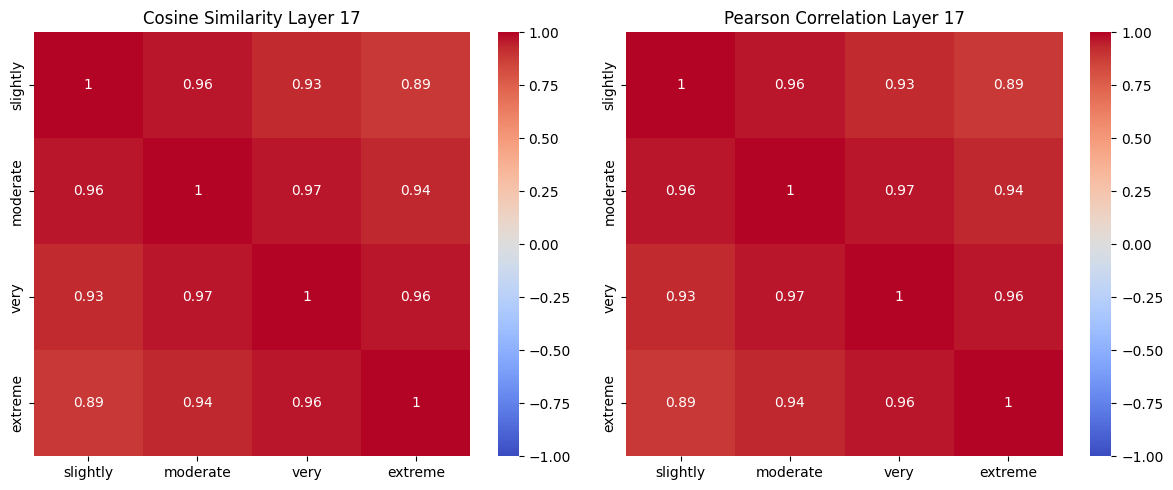

In [66]:
from scipy.stats import pearsonr
import numpy as np

steering_vectors_list = [slightly_nervous_steer,
    nervous_steer,
    very_nervous_steer,
    super_nervous_steer]

n = len(steering_vectors_list)
layers = sorted(steering_vectors_list[0].layer_activations.keys())


cosine_sims = np.zeros((len(layers), n, n))
pearson_corrs = np.zeros((len(layers), n, n))

def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b, dim=0).item()

for li, layer in enumerate(layers):
    for i in range(n):
        for j in range(n):
            vec_i = steering_vectors_list[i].layer_activations[layer]
            vec_j = steering_vectors_list[j].layer_activations[layer]

            cosine_sims[li, i, j] = cosine_similarity(vec_i, vec_j)

            vi_np = vec_i.cpu().numpy()
            vj_np = vec_j.cpu().numpy()
            corr, _ = pearsonr(vi_np, vj_np)
            pearson_corrs[li, i, j] = corr


for li, layer in enumerate(layers):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cosine_sims[li], annot=True, xticklabels=["slightly", "moderate", "very", "extreme"],
                yticklabels=["slightly", "moderate", "very", "extreme"], ax=axs[0], vmin=-1, vmax=1, cmap="coolwarm")
    axs[0].set_title(f"Cosine Similarity Layer {layer}")

    sns.heatmap(pearson_corrs[li], annot=True, xticklabels=["slightly", "moderate", "very", "extreme"],
                yticklabels=["slightly", "moderate", "very", "extreme"], ax=axs[1], vmin=-1, vmax=1, cmap="coolwarm")
    axs[1].set_title(f"Pearson Correlation Layer {layer}")

    plt.tight_layout()
    plt.show()


# Take a look into linearity of each activation

In [11]:
# from steering_vectors import record_activations, extract_activations

In [86]:
# pos_acts_by_layer, neg_acts_by_layer = extract_activations(
#     model=model,
#     tokenizer=tokenizer,
#     training_samples=nervous_pairs[:1000],
#     layers=list(range(model.config.num_hidden_layers)),
#     layer_type="decoder_block",
#     batch_size=1,
#     show_progress=True,
#     move_to_cpu=True
# )

Extracting activations: 100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


In [82]:
# def make_save_structure(pos_acts_by_layer, neg_acts_by_layer, pairs):
#     paired_data = []
#     layer_ids = list(pos_acts_by_layer.keys())
#     for i, pair_prompts in enumerate(pairs):

#         pos_embeddings = {}
#         neg_embeddings = {}

#         for layer_num in layer_ids:
#             pos_embeddings[layer_num] = pos_acts_by_layer[layer_num][i]
#             neg_embeddings[layer_num] = neg_acts_by_layer[layer_num][i]

#         paired_data.append({
#             "pair_index": i,
#             "prompts": pair_prompts,
#             "pos": pos_embeddings,
#             "neg": neg_embeddings
#         })

#     return paired_data

In [87]:
# very_nervous_data = make_save_structure(pos_acts_by_layer, neg_acts_by_layer, nervous_pairs[:1000])
# joblib.dump(very_nervous_data, "/content/drive/MyDrive/llm_steering/activations/nervous_activations.pkl")

['/content/drive/MyDrive/llm_steering/activations/nervous_activations.pkl']

In [3]:
import joblib

slightly_nervous_data = joblib.load("/content/drive/MyDrive/llm_steering/activations/slightly_nervous_activations.pkl")
nervous_data = joblib.load("/content/drive/MyDrive/llm_steering/activations/nervous_activations.pkl")
very_nervous_data = joblib.load("/content/drive/MyDrive/llm_steering/activations/very_nervous_activations.pkl")
super_nervous_data = joblib.load("/content/drive/MyDrive/llm_steering/activations/super_nervous_activations.pkl")

# Проверим как для одной пары (pos, neg) будут вести себя pre-steer векторы на разных слоях

In [92]:
def get_dif_activation(pos_tensor, neg_tensor):
    return pos_tensor - neg_tensor

In [130]:
layer = 14

l_1_activation = get_dif_activation(very_nervous_data[0]['pos'][1], very_nervous_data[0]['neg'][1])
l_13_activation = get_dif_activation(very_nervous_data[0]['pos'][layer-1], very_nervous_data[0]['neg'][layer-1])
l_14_activation = get_dif_activation(very_nervous_data[0]['pos'][layer], very_nervous_data[0]['neg'][layer])
l_15_activation = get_dif_activation(very_nervous_data[0]['pos'][layer+1], very_nervous_data[0]['neg'][layer+1])
l_30_activation = get_dif_activation(very_nervous_data[0]['pos'][30], very_nervous_data[0]['neg'][30])

In [118]:
full = torch.stack([l_13_activation, l_14_activation, l_15_activation], dim=1).squeeze(0)

rank = torch.linalg.matrix_rank(full.to(torch.float32))
print(rank)

tensor(3)


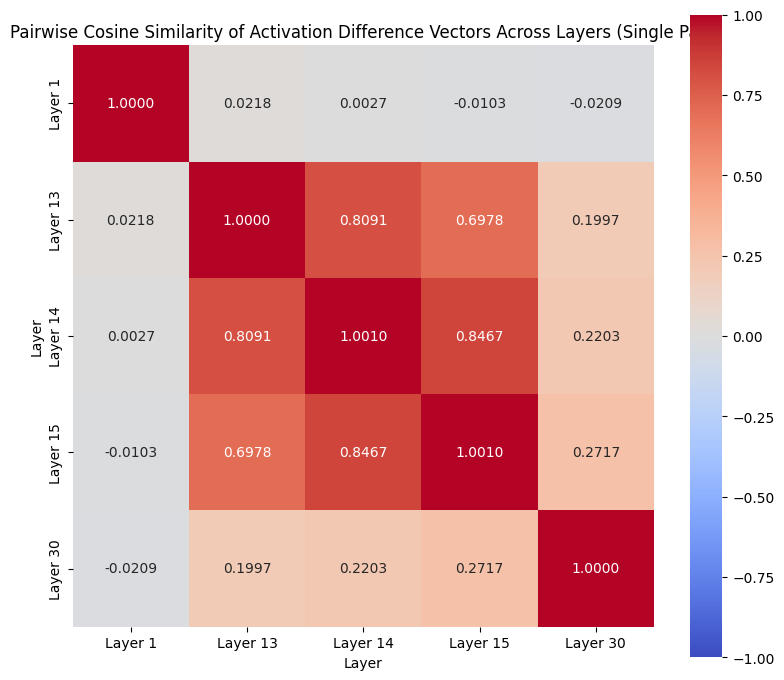

In [137]:
import seaborn as sns

activation_vectors = [
    l_1_activation,
    l_13_activation,
    l_14_activation,
    l_15_activation,
    l_30_activation
]

layer_labels = ['Layer 1', 'Layer 13', 'Layer 14', 'Layer 15', 'Layer 30']
n_vectors = len(activation_vectors)

similarity_matrix = np.zeros((n_vectors, n_vectors))

for i in range(n_vectors):
    for j in range(n_vectors):
        sim = torch.cosine_similarity(activation_vectors[i].squeeze(), activation_vectors[j].squeeze(), dim=0).item()
        similarity_matrix[i, j] = sim

df_similarity = pd.DataFrame(similarity_matrix, index=layer_labels, columns=layer_labels)

plt.figure(figsize=(8, 7))
sns.heatmap(df_similarity, annot=True, cmap="coolwarm", fmt=".4f", vmin=-1, vmax=1, square=True)
plt.title('Pairwise Cosine Similarity of some Pre-steer vectors')
plt.xlabel('Layer')
plt.ylabel('Layer')
plt.tight_layout()
plt.show()

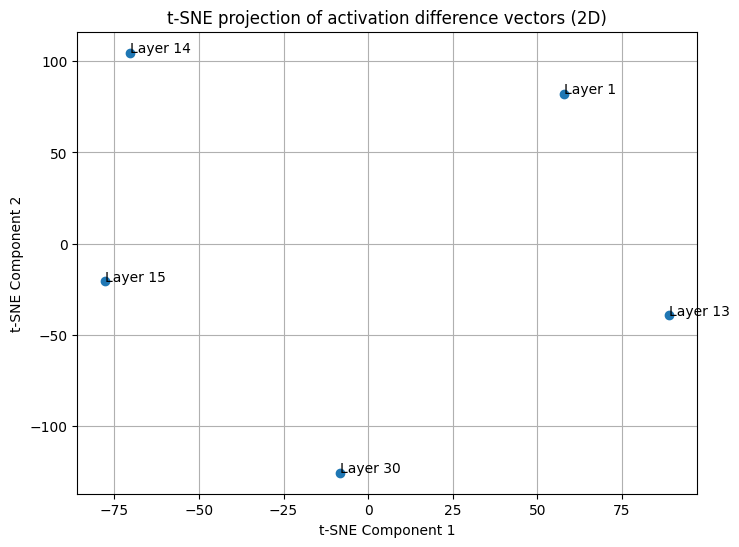

In [133]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

l_1_activation_np = l_1_activation.squeeze().cpu().numpy()
l_13_activation_np = l_13_activation.squeeze().cpu().numpy()
l_14_activation_np = l_14_activation.squeeze().cpu().numpy()
l_15_activation_np = l_15_activation.squeeze().cpu().numpy()
l_30_activation_np = l_30_activation.squeeze().cpu().numpy()

X = np.vstack([l_1_activation_np, l_13_activation_np, l_14_activation_np, l_15_activation_np, l_30_activation_np])

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=4)
X_tsne_2d = tsne_2d.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1])
labels = ['Layer 1', 'Layer 13', 'Layer 14', 'Layer 15', 'Layer 30']
for i, label in enumerate(labels):
    plt.annotate(label, (X_tsne_2d[i, 0], X_tsne_2d[i, 1]))

plt.title('t-SNE projection of activation difference vectors (2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

Пока получается, что внутри одной пары неусредненные активации pre-steer vectors не коллинеарны между собой

## Будем рассматривать пока только 2-3 слоя в промежутке 13 - 15

In [6]:
import torch

In [4]:
from typing import List, Dict

def make_one_tensor(type_data: List[Dict], layer: int = 13):
    collected = []

    for i, item in enumerate(type_data):
        tensor = item['pos'][layer] - item['neg'][layer]
        collected.append(tensor.squeeze(0))

    return torch.stack(collected)

In [7]:
tensor_13_super_nervous = make_one_tensor(super_nervous_data)
tensor_14_super_nervous = make_one_tensor(super_nervous_data, layer=14)
tensor_15_super_nervous = make_one_tensor(super_nervous_data, layer=15)

tensor_13_very_nervous = make_one_tensor(very_nervous_data)
tensor_14_very_nervous = make_one_tensor(very_nervous_data, layer=14)
tensor_15_very_nervous = make_one_tensor(very_nervous_data, layer=15)

tensor_13_nervous = make_one_tensor(nervous_data)
tensor_14_nervous = make_one_tensor(nervous_data, layer=14)
tensor_15_nervous = make_one_tensor(nervous_data, layer=15)

tensor_13_slightly_nervous = make_one_tensor(slightly_nervous_data)
tensor_14_slightly_nervous = make_one_tensor(slightly_nervous_data, layer=14)
tensor_15_slightly_nervous = make_one_tensor(slightly_nervous_data, layer=15)

In [182]:
import torch
import torch.nn.functional as F

def check_pairwise_collinearity(tensor_a: torch.Tensor, tensor_b: torch.Tensor, threshold: float = 0.89) -> torch.Tensor:
    """
    Возвращает булеву матрицу (size: [A, B]), где (i, j) = True если a[i] и b[j] коллинеарны (по косинусной близости).
    """
    a_norm = F.normalize(tensor_a, p=2, dim=1)
    b_norm = F.normalize(tensor_b, p=2, dim=1)

    cosine_sim = a_norm @ b_norm.T

    return (cosine_sim.abs() >= threshold)

result = check_pairwise_collinearity(tensor_15_super_nervous, tensor_15_slightly_nervous)

print(result.sum())

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Bool

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


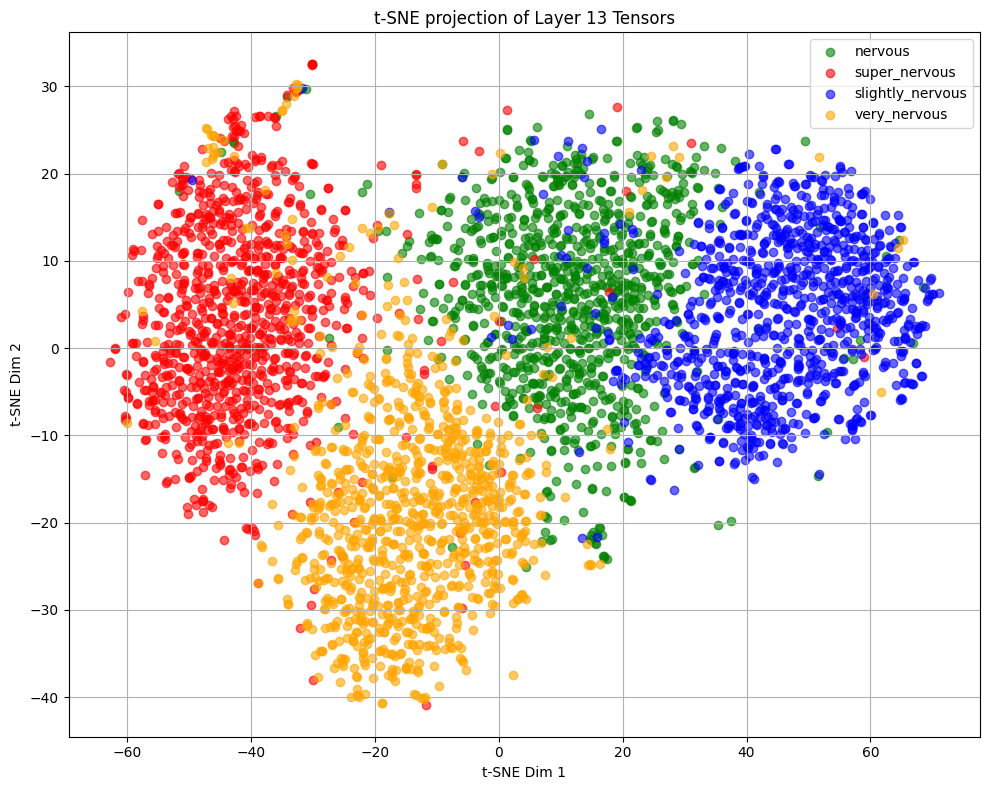

In [191]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Склеиваем тензоры
tensors = [
    tensor_13_super_nervous,
    tensor_13_very_nervous,
    tensor_13_nervous,
    tensor_13_slightly_nervous,
]
labels = ['super_nervous'] * 1000 + ['very_nervous'] * 1000 + ['nervous'] * 1000 + ['slightly_nervous'] * 1000

# Переводим в numpy
data = torch.cat(tensors, dim=0).numpy()

# t-SNE до 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
reduced = tsne.fit_transform(data)

# Визуализация
plt.figure(figsize=(10, 8))
colors = {
    'super_nervous': 'red',
    'very_nervous': 'orange',
    'nervous': 'green',
    'slightly_nervous': 'blue',
}

for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, alpha=0.6, color=colors[label])

plt.title('t-SNE projection of Layer 13 Tensors')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


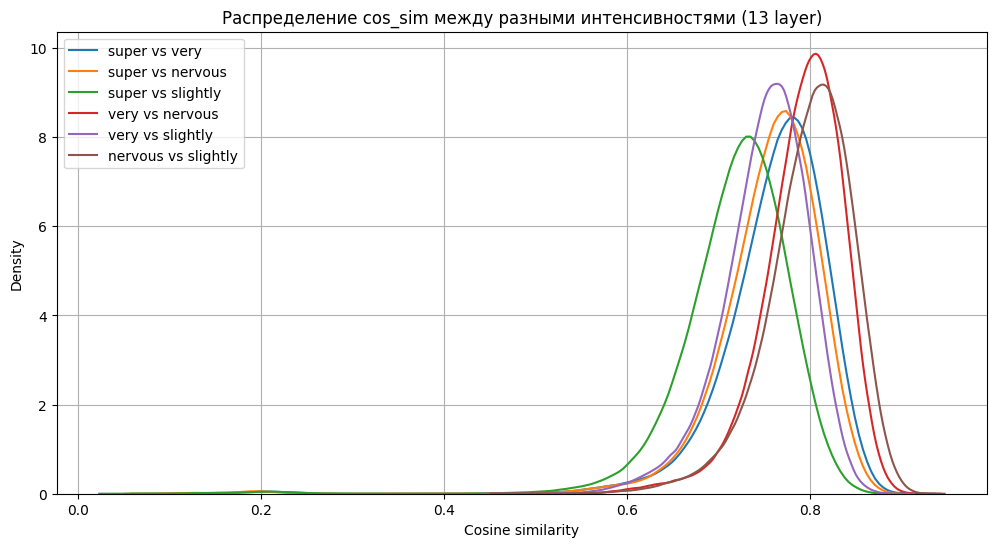

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Считаем попарные similarity между тензорами
pairs = {
    ('super', 'very'): cosine_similarity(tensor_13_super_nervous, tensor_13_very_nervous),
    ('super', 'nervous'): cosine_similarity(tensor_13_super_nervous, tensor_13_nervous),
    ('super', 'slightly'): cosine_similarity(tensor_13_super_nervous, tensor_13_slightly_nervous),
    ('very', 'nervous'): cosine_similarity(tensor_13_very_nervous, tensor_13_nervous),
    ('very', 'slightly'): cosine_similarity(tensor_13_very_nervous, tensor_13_slightly_nervous),
    ('nervous', 'slightly'): cosine_similarity(tensor_13_nervous, tensor_13_slightly_nervous),
}

# Визуализация распределений
plt.figure(figsize=(12, 6))
for (a, b), sim in pairs.items():
    sns.kdeplot(sim.flatten(), label=f'{a} vs {b}')

plt.title('Распределение cos_sim между разными интенсивностями (13 layer)')
plt.xlabel('Cosine similarity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


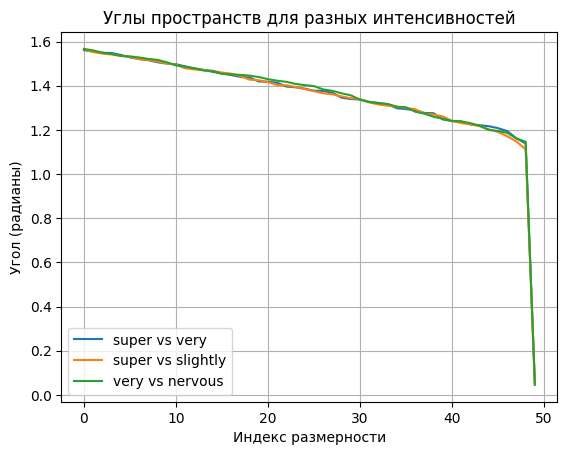

In [13]:
from scipy.linalg import subspace_angles

def get_top_k_basis(tensor, k=50):
    tensor = tensor.to(dtype=torch.float32)
    u, _, _ = torch.linalg.svd(tensor, full_matrices=False)
    return u[:, :k]

# Получаем подпространства
basis_super = get_top_k_basis(tensor_15_super_nervous)
basis_very = get_top_k_basis(tensor_15_very_nervous)
basis_nervous = get_top_k_basis(tensor_15_nervous)
basis_slightly = get_top_k_basis(tensor_15_slightly_nervous)

# Углы между подпространствами
angles_super_very = subspace_angles(basis_super.numpy(), basis_very.numpy())
angles_super_slightly = subspace_angles(basis_super.numpy(), basis_slightly.numpy())
angles_very_nervous = subspace_angles(basis_very.numpy(), basis_nervous.numpy())

# Визуализация
plt.plot(angles_super_very, label='super vs very')
plt.plot(angles_super_slightly, label='super vs slightly')
plt.plot(angles_very_nervous, label='very vs nervous')
plt.ylabel('Угол (радианы)')
plt.xlabel('Индекс размерности')
plt.title('Углы пространств для разных интенсивностей')
plt.legend()
plt.grid(True)
plt.show()